# measure probabilistic stellar mass function for entire BGS sample

$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import numpy as np
import fitsio
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [2]:
import copy
import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# compile $M_*$ posteriors

In [ ]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.hdf5'))

In [ ]:
bgs[:5]

In [ ]:
has_posterior = (bgs['provabgs_z_max'].data != -999.)
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

print('BGS Bright: %i galaxies' % np.sum(is_bgs_bright & has_posterior))
print('BGS Faint: %i galaxies' % np.sum(is_bgs_faint & has_posterior))

In [ ]:
bgs = bgs[has_posterior]
print('%i BGS All galaxies with posteriors' % len(bgs))

# calculate $V_{\rm max}$ with *Planck (2013)* cosmology

In [ ]:
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
bgs['Vmax'] = Planck13.comoving_volume(bgs['provabgs_z_max'].data).value * Planck13.h**3 * f_area # (Mpc/h)^3

In [ ]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, bgs['provabgs_logMstar_bf'].data, s=1, #s=bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data, 
            c='C0', label='BGS All')
sub.legend(loc='lower right', fontsize=25, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.set_ylim(6., 13.)

In [ ]:
logM_posteriors = bgs['provabgs_logMstar'].data
vmaxes = bgs['Vmax'].data

In [ ]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=20, replace=False): 
    plt.hist(logM_posteriors[i,:], bins=5, alpha=0.5, density=True)
plt.xlim(7., 12.5)

# check weights
Lets make sure that the systematic correction weights are all sensible

In [ ]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), [0., 0.1, 0.2, 0.3], [0.1, 0.2, 0.3, 0.4]):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) 
    sub.scatter(bgs['provabgs_w_zfail'].data[zlim], bgs['provabgs_w_fibassign'].data[zlim])
sub.set_ylim(0., None)

In [ ]:
for i, zmin, zmax in zip(range(4), [0., 0.1, 0.2, 0.3], [0.1, 0.2, 0.3, 0.4]):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    print(w_import[zlim].min(), w_import[zlim].max())    
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    print(w_import[zlim].min(), w_import[zlim].max())

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- incorrectly

Lets just look at the median of the posteriors

In [ ]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), [0., 0.1, 0.2, 0.3], [0.1, 0.2, 0.3, 0.4]):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), bins=40, range=(6., 13.), color='C%i' % i, 
                 linestyle='--', histtype='step', density=True)
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), weights=w_import[zlim], bins=40, range=(6., 13.), 
                 color='C%i' % i, linewidth=2, histtype='step', alpha=0.5, density=True)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
plt.show()

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- correctly

In [17]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.sample(N)
    
    
def Loss(qphi, post, w): 
    ''' calculate loss
    
    \sum_i^Ng w_i * \log \sum_j^Ns qphi(\theta_ij)
    
    '''
    logqphi = qphi.log_prob(post.flatten()[:,None]).reshape(post.shape)

    return -torch.sum(w * torch.logsumexp(logqphi, axis=1))  

In [18]:
zmins = [0.01 + 0.04 * i for i in range(10)]
zmaxs = [0.01 + 0.04 * (i+1) for i in range(10)]

5983 galaxies
1.0 973.2228778699958


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


GMM with 8 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.14550e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.14550e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.14550e+00
GMM with 80 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -8.13612e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.13612e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.13612e+00
GMM with 27 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>31 	 -8.12235e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.12235e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.12235e+00
GMM with 64 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.13297e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.13297e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.13297e+00
GMM with 91 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -8.13553e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.13553e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.13553e+00


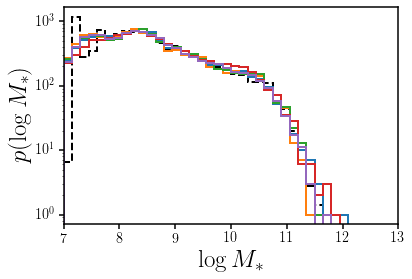

14335 galaxies
1.0000000000000204 1185.1334528412067
GMM with 19 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>42 	 -8.95638e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.95638e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.95638e+00
GMM with 8 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>48 	 -8.96812e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.96812e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.96812e+00
GMM with 87 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -8.98287e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.98287e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.98287e+00
GMM with 7 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>29 	 -8.98644e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.98644e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.98644e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>32 	 -9.00735e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -9.00735e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -9.00735e+00


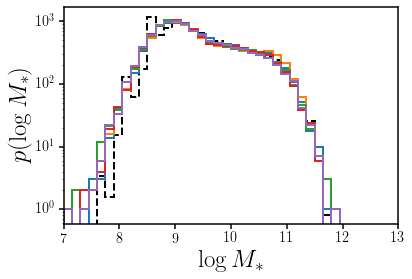

18897 galaxies
1.000000000000832 2875.312434271888
GMM with 98 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>55 	 -5.40583e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -5.40701e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40701e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>79 	 -5.41169e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.41169e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.41169e+00
GMM with 62 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -5.40758e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40758e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40758e+00
GMM with 17 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -5.40604e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40604e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40604e+00
GMM with 90 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -5.41188e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.41188e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.41188e+00


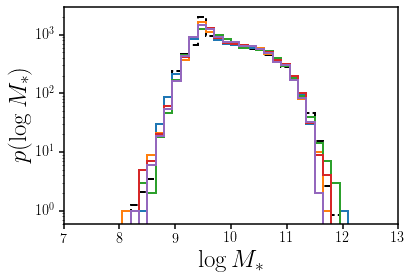

27652 galaxies
1.0000000000641258 635.6729504266035
GMM with 9 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>40 	 -5.74180e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74180e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74180e+00
GMM with 98 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>33 	 -5.74036e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74036e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74036e+00
GMM with 38 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>35 	 -5.74030e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74030e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74030e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -5.74136e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74136e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74136e+00
GMM with 13 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -5.74341e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74341e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.74341e+00


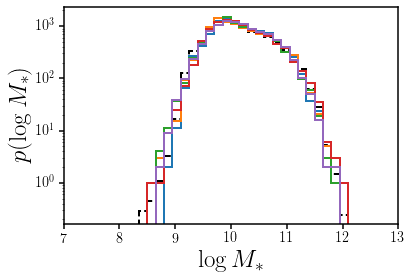

28564 galaxies
1.0 612.0132474339786
GMM with 8 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>38 	 -6.20569e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20569e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20569e+00
GMM with 90 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>61 	 -6.20622e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20622e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20622e+00
GMM with 32 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>52 	 -6.21552e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21552e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21552e+00
GMM with 19 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>33 	 -6.20445e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20445e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20445e+00
GMM with 39 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -6.20426e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20426e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.20426e+00


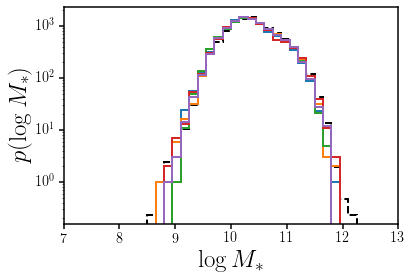

In [19]:
for zmin, zmax in zip(zmins[:5], zmaxs):
    fgmm = os.path.join(dat_dir, 'psmf.gmm.bgs_any.z%.2f_%.2f.best.pt' % (zmin, zmax))

    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)
    print('%i galaxies' % np.sum(zlim))
    
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    print(w_import[zlim].min(), w_import[zlim].max())

    x_data = torch.tensor(logM_posteriors[zlim].astype(np.float32)).to(device)
    w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)
    
    # make sure there aren't any Nans
    assert torch.sum(np.isnan(x_data.cpu())) == 0 
    assert torch.sum(np.isnan(w_data.cpu())) == 0
        
    batch_size = 128
    Ntrain = int(0.9 * x_data.shape[0])
    Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

    trainloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
            batch_size=batch_size,
            shuffle=True)

    validloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
            batch_size=batch_size)
    
    num_iter = 1000
    patience = 20

    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
             weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
             range=(7., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=2)
    
    best_flows, best_valid_losses, vls = [], [], []
    for i in range(5): 
        ncomp = int(np.random.uniform(5, 100))
        flow = GaussianMixtureModel(n_components=ncomp, 
                                    mmin=logM_posteriors[zlim].min(), 
                                    mmax=logM_posteriors[zlim].max())
        flow.to(device)
        print('GMM with %i components' % ncomp)
    
        best_valid_loss = np.inf
        valid_losses = []
        for lr in [1e-2, 1e-3, 1e-4]: 
            optimizer = optim.Adam(flow.parameters(), lr=lr)
            best_epoch = 0

            t = trange(num_iter, leave=False)
            for epoch in t:
                train_loss = 0.
                for batch in trainloader: 
                    optimizer.zero_grad()
                    _post, _w = batch
                    _post = _post.to(device)
                    _w = _w.to(device)

                    loss = Loss(flow, _post, _w)
                    loss.backward()
                    train_loss += loss.item()
                    optimizer.step()
                train_loss /= len(trainloader.dataset)

                with torch.no_grad():
                    valid_loss = 0.
                    for batch in validloader: 
                        _post, _w = batch
                        _post = _post.to(device)
                        _w = _w.to(device)

                        loss = Loss(flow, _post, _w)                
                        valid_loss += loss.item()
                    valid_loss /= len(validloader.dataset)           
                    valid_losses.append(valid_loss)

                t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                                  (epoch, train_loss, valid_loss), refresh=False)

                if valid_loss < best_valid_loss: 
                    best_valid_loss = valid_loss
                    best_epoch = epoch
                    best_flow = copy.deepcopy(flow)
                else: 
                    if best_epoch < epoch - patience: 
                        print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                        break
            
        with torch.no_grad(): 
            post_prime = best_flow.sample((10000,))
            _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)

        best_flows.append(best_flow)
        best_valid_losses.append(best_valid_loss)
        vls.append(valid_losses)
        
    sub.set_xlabel(r'$\log M_*$', fontsize=25)
    sub.set_xlim(7., 13.)
    sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
    sub.set_yscale('log')
    plt.show()
    
    ibest = np.argmin(best_valid_losses)
    torch.save(best_flows[ibest], fgmm)            

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


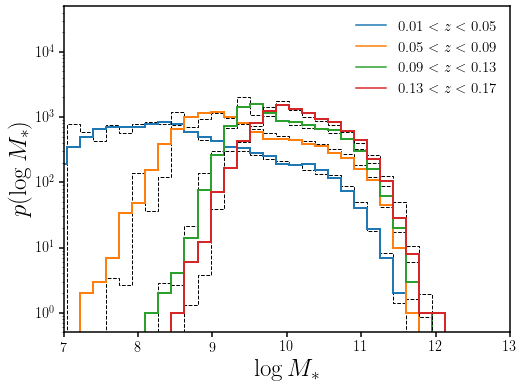

In [20]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_any.z%.2f_%.2f.best.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((10000,))
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
                 weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
                 range=(6., 13.), bins=40, histtype='step', 
                 color='k', linestyle='--', linewidth=1) 
    
    _ = sub.hist(np.array(post_prime.detach().cpu()), range=(6., 13.), bins=40, 
                 color='C%i' % i, histtype='step', linewidth=2)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

sub.legend(loc='upper right', fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7., 13.)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-1, 5e4)
plt.show()

# normalizing the pSMF

In [21]:
_zmin, _zmax, mlim = np.loadtxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[0, 1, 2])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


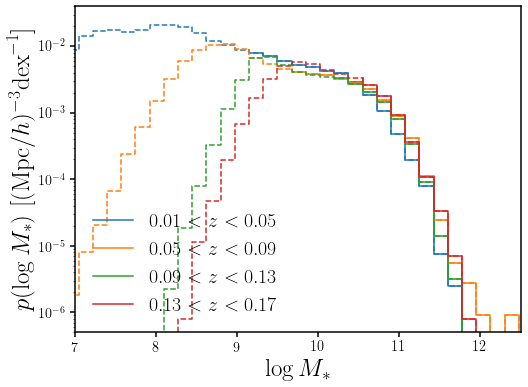

In [22]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_any.z%.2f_%.2f.best.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization    
    #_ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
    #             weights=w_import[zlim]*norm, #10000./np.sum(w_import[zlim]), 
    #             range=(6., 13.), bins=40, histtype='step', 
    #             color='k', linestyle='--', linewidth=1) 
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
    #sub.axvline(mlim[2*i+1], color='C%i' % i, linestyle=':')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-7, 4e-2)
plt.show()

# jack knife uncertainties

In [23]:
fields = [
    ((bgs['RA'] > 140) & (bgs['RA'] < 160)), 
    ((bgs['RA'] > 160) & (bgs['RA'] < 185) & (bgs['DEC'] > -10) & (bgs['DEC'] < 10)), 
    ((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8)), 
    ((bgs['RA'] > 210) & (bgs['RA'] < 224) & (bgs['DEC'] > -5) & (bgs['DEC'] < 5) & ~((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8))),
    ((bgs['RA'] > 190) & (bgs['RA'] < 200) & (bgs['DEC'] > 20) & (bgs['DEC'] < 30)), 
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),     
    ((bgs['RA'] > 250) & (bgs['RA'] < 260) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),
    ((bgs['RA'] > 230) & (bgs['RA'] < 255) & (bgs['DEC'] > 40) & (bgs['DEC'] < 45)),    
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 45) & (bgs['DEC'] < 58)),        
    ((bgs['RA'] > 235) & (bgs['RA'] < 255) & (bgs['DEC'] > 50) & (bgs['DEC'] < 60)), 
    ((bgs['RA'] > 180) & (bgs['RA'] < 200) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70)), 
    ((bgs['RA'] > 260) & (bgs['RA'] < 280) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70))    
]

A_fields = [164.965, 156.064, 164.917, 138.785, 155.972, 164.848, 165.120, 148.024, 
            165.015, 165.030, 164.890, 156.806]

Text(0, 0.5, 'Dec')

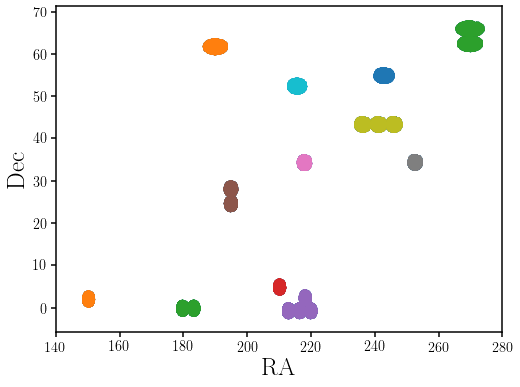

In [24]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['RA'], bgs['DEC'], s=1)
for field in fields: 
    sub.scatter(bgs['RA'][field], bgs['DEC'][field], s=1)
sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(140, 280)
sub.set_ylabel('Dec', fontsize=25)
#sub.set_ylim(-10, 10)

In [25]:
num_iter = 1000
patience = 20

for zmin, zmax in zip(zmins[:5], zmaxs[:5]):
    for i_jack, field in enumerate(fields): # loop through jackknife fields
        fgmm = os.path.join(dat_dir, 'psmf.gmm.bgs_any.z%.2f_%.2f.jack%i.best.pt' % (zmin, zmax, i_jack))
        
        # Vmax based importance weights
        zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & ~field & (bgs['provabgs_w_zfail'].data > 0)

        v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
        v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3

        w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
        w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data

        x_data = torch.tensor(logM_posteriors[zlim].astype(np.float32)).to(device)
        w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)

        batch_size = 128
        Ntrain = int(0.9 * x_data.shape[0])
        Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

        trainloader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
                batch_size=batch_size,
                shuffle=True)

        validloader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
                batch_size=batch_size)

        best_flows, best_valid_losses = [], []
        for i in range(3): 
            ncomp = int(np.random.uniform(5, 100))
            flow = GaussianMixtureModel(n_components=ncomp, 
                                        mmin=logM_posteriors[zlim].min(), 
                                        mmax=logM_posteriors[zlim].max())
            flow.to(device)
            print('GMM with %i components' % ncomp)
            
            best_valid_loss = np.inf
            valid_losses = [] 
            for lr in [1e-2, 1e-3, 1e-4]:
                optimizer = optim.Adam(flow.parameters(), lr=lr)
                best_epoch = 0

                t = trange(num_iter, leave=False)
                for epoch in t:
                    train_loss = 0.
                    for batch in trainloader: 
                        optimizer.zero_grad()
                        _post, _w = batch
                        _post = _post.to(device)
                        _w = _w.to(device)

                        loss = Loss(flow, _post, _w)
                        loss.backward()
                        train_loss += loss.item()
                        optimizer.step()
                    train_loss /= len(trainloader.dataset)

                    with torch.no_grad():
                        valid_loss = 0.
                        for batch in validloader: 
                            _post, _w = batch
                            _post = _post.to(device)
                            _w = _w.to(device)

                            loss = Loss(flow, _post, _w)                
                            valid_loss += loss.item()
                        valid_loss /= len(validloader.dataset)           
                        valid_losses.append(valid_loss)

                    t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                                      (epoch, train_loss, valid_loss), refresh=False)

                    if valid_loss < best_valid_loss: 
                        best_valid_loss = valid_loss
                        best_epoch = epoch
                        best_flow = copy.deepcopy(flow)
                    else: 
                        if best_epoch < epoch - patience: 
                            print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                            break

            best_flows.append(best_flow)
            best_valid_losses.append(best_valid_loss)
            
        ibest = np.argmin(best_valid_losses)
        torch.save(best_flows[ibest], fgmm)

GMM with 60 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.27406e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.27406e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.27406e+00
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.32082e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.32082e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.32082e+00
GMM with 36 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.28939e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.28939e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.28939e+00
GMM with 62 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>37 	 -7.55642e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -7.55746e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -7.55746e+00
GMM with 56 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>37 	 -7.54326e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -7.54326e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -7.54326e+00
GMM with 62 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -7.53952e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -7.53952e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -7.53952e+00
GMM with 58 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.19989e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.19989e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.19989e+00
GMM with 74 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>27 	 -8.23761e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.23761e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.23761e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.29703e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.29703e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.29703e+00
GMM with 19 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>35 	 -8.58047e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.58047e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.58047e+00
GMM with 64 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>36 	 -8.54605e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.54605e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.54605e+00
GMM with 25 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -8.60651e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.60651e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.60651e+00
GMM with 80 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>36 	 -8.90963e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.90963e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.90963e+00
GMM with 32 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -8.93191e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.93191e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.93191e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -8.94596e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.94596e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.94596e+00
GMM with 75 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.46669e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.46669e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.46669e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>39 	 -8.46664e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.46664e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.46664e+00
GMM with 49 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>46 	 -8.46175e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.46175e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.46175e+00
GMM with 17 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.18074e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.18074e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.18074e+00
GMM with 96 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -8.18917e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.18917e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.18917e+00
GMM with 7 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -8.20617e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.20617e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.20617e+00
GMM with 22 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -8.02193e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.02193e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.02193e+00
GMM with 62 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>72 	 -8.07753e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.07753e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.07753e+00
GMM with 63 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.00598e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.00598e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.00598e+00
GMM with 38 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>44 	 -8.33597e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.33597e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.33597e+00
GMM with 75 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>31 	 -8.33719e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.33719e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.33719e+00
GMM with 99 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>34 	 -8.34107e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.34107e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.34107e+00
GMM with 48 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>27 	 -8.26002e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.26002e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.26002e+00
GMM with 54 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>40 	 -8.27440e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.27440e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.27440e+00
GMM with 96 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>29 	 -8.25897e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.25897e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.25897e+00
GMM with 77 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.20653e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.20653e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.20653e+00
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.22015e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.22015e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.22015e+00
GMM with 92 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -8.20464e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.20464e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.20464e+00
GMM with 13 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -8.59187e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.59187e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.59187e+00
GMM with 86 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>27 	 -8.57783e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.57783e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.57783e+00
GMM with 33 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -8.55386e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.55386e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.55386e+00
GMM with 68 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>46 	 -5.91115e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91115e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91115e+00
GMM with 98 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>61 	 -5.91088e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91088e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91088e+00
GMM with 41 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>67 	 -5.90693e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.90693e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.90693e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>42 	 -8.80434e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.80434e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.80434e+00
GMM with 52 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>51 	 -8.81701e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.81701e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.81701e+00
GMM with 32 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>43 	 -8.82797e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.82797e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.82797e+00
GMM with 61 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>42 	 -5.93248e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93248e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93248e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.91369e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91369e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91369e+00
GMM with 64 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>96 	 -5.94735e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.94735e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.94735e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>59 	 -6.03323e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.03323e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.03323e+00
GMM with 58 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>62 	 -6.02122e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.02122e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.02122e+00
GMM with 41 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>81 	 -6.04189e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.04189e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.04189e+00
GMM with 83 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>69 	 -5.92192e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92192e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92192e+00
GMM with 39 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -5.91005e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91005e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91005e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>69 	 -5.93472e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93472e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93472e+00
GMM with 67 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>65 	 -5.89771e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.89771e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.89771e+00
GMM with 56 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -5.88854e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.88854e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.88854e+00
GMM with 17 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>90 	 -5.90579e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.90579e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.90579e+00
GMM with 98 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>78 	 -5.91455e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91455e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91455e+00
GMM with 14 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.89641e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.89641e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.89641e+00
GMM with 84 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>53 	 -5.90910e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.90910e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.90910e+00
GMM with 34 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.82761e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.82761e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.82761e+00
GMM with 63 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -5.83317e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.83317e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.83317e+00
GMM with 78 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -5.82961e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.82961e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.82961e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>33 	 -5.92549e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92549e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92549e+00
GMM with 34 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>37 	 -5.92732e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92732e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92732e+00
GMM with 64 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>36 	 -5.92827e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92827e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92827e+00
GMM with 63 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -5.91314e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91314e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91314e+00
GMM with 34 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>46 	 -5.92356e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92356e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.92356e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>97 	 -5.93209e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93209e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93209e+00
GMM with 34 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -8.87657e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.87657e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.87657e+00
GMM with 92 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -8.83285e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.83285e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.83285e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -8.83781e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.83781e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -8.83781e+00
GMM with 29 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>83 	 -5.93701e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93701e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93701e+00
GMM with 39 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>60 	 -5.93388e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93388e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.93388e+00
GMM with 85 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -5.91687e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91687e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.91687e+00
GMM with 69 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.47115e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.47115e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.47115e+00
GMM with 33 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>73 	 -5.47417e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.47417e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.47417e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>65 	 -5.47646e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.47646e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.47646e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -5.25255e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.25255e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.25255e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -5.25073e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.25073e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.25073e+00
GMM with 78 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -5.24538e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.24538e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.24538e+00
GMM with 87 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>35 	 -5.48036e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48036e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48036e+00
GMM with 61 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>70 	 -5.48505e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48505e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48505e+00
GMM with 85 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>125 	 -5.48776e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48776e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48776e+00
GMM with 41 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>77 	 -5.67288e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.67288e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.67288e+00
GMM with 63 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.67244e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.67244e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.67244e+00
GMM with 59 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>117 	 -5.67934e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.67934e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.67934e+00
GMM with 80 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>44 	 -5.43904e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43904e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43904e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -5.43658e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43658e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43658e+00
GMM with 67 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.43601e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -5.43872e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43872e+00
GMM with 46 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>68 	 -5.46285e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46285e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46285e+00
GMM with 58 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>73 	 -5.46575e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46575e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46575e+00
GMM with 81 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -5.46675e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46675e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46675e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.45639e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -5.45820e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.45820e+00
GMM with 7 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -5.46161e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46161e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46161e+00
GMM with 35 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>50 	 -5.46146e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46146e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46146e+00
GMM with 85 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>94 	 -5.48450e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48450e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48450e+00
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>51 	 -5.48419e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48419e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48419e+00
GMM with 43 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>57 	 -5.48028e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48028e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.48028e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>27 	 -5.41744e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.41744e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.41744e+00
GMM with 7 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>54 	 -5.42520e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.42520e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.42520e+00
GMM with 51 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>44 	 -5.42091e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.42097e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.42097e+00
GMM with 45 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>64 	 -5.44391e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.44391e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.44391e+00
GMM with 55 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.43285e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43285e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43285e+00
GMM with 41 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -5.43321e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43321e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.43321e+00
GMM with 40 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -5.09864e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.09864e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.09864e+00
GMM with 85 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>23 	 -5.10605e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.10605e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.10605e+00
GMM with 89 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>49 	 -5.10493e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.10493e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.10493e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>29 	 -5.46065e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46065e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.46065e+00
GMM with 75 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>38 	 -5.45822e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.45822e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.45822e+00
GMM with 16 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>33 	 -5.45835e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.45835e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.45835e+00
GMM with 33 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>41 	 -5.76282e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76282e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76282e+00
GMM with 67 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>46 	 -5.76209e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76209e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76209e+00
GMM with 21 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>48 	 -5.76256e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76256e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76256e+00
GMM with 86 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>39 	 -6.34773e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.34773e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.34773e+00
GMM with 71 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>65 	 -6.34320e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.34320e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.34320e+00
GMM with 65 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -6.31448e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.31448e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.31448e+00
GMM with 50 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -5.75744e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75744e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75744e+00
GMM with 25 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>39 	 -5.75729e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75729e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75729e+00
GMM with 20 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.75925e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75925e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75925e+00
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>64 	 -5.75828e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75828e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75828e+00
GMM with 65 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.76366e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76366e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76366e+00
GMM with 20 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>32 	 -5.75778e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75778e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75778e+00
GMM with 58 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>27 	 -5.75780e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75780e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75780e+00
GMM with 19 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -5.75852e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75852e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75852e+00
GMM with 8 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>44 	 -5.75850e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75850e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75850e+00
GMM with 49 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.76526e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76526e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76526e+00
GMM with 53 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.76566e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76566e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76566e+00
GMM with 91 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>34 	 -5.76653e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76653e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76653e+00
GMM with 42 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -5.76073e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76073e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76073e+00
GMM with 6 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>52 	 -5.76336e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76336e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76336e+00
GMM with 71 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>46 	 -5.75929e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75929e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75929e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -6.14551e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.14551e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.14551e+00
GMM with 41 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -6.19861e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.19861e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.19861e+00
GMM with 92 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -6.14762e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.14762e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.14762e+00
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -5.75886e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75886e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75886e+00
GMM with 60 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>51 	 -5.75874e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75874e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75874e+00
GMM with 25 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>29 	 -5.75699e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75699e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75699e+00
GMM with 68 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -5.75923e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75923e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75923e+00
GMM with 98 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.75832e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75832e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75832e+00
GMM with 34 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -5.76118e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76118e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.76118e+00
GMM with 69 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>51 	 -6.32795e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.32795e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.32795e+00
GMM with 40 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>37 	 -6.30977e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.30977e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.30977e+00
GMM with 65 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>39 	 -6.29990e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.29990e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.29990e+00
GMM with 88 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -5.75581e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75581e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75581e+00
GMM with 41 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -5.75563e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75563e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75563e+00
GMM with 62 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>26 	 -5.75599e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75599e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.75599e+00
GMM with 20 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>35 	 -6.24204e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24204e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24204e+00
GMM with 28 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>30 	 -6.24101e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24101e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24101e+00
GMM with 45 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>36 	 -6.23943e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.23943e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.23943e+00
GMM with 25 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -6.36722e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.36722e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.36722e+00
GMM with 5 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>25 	 -6.36871e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.36871e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.36871e+00
GMM with 76 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>35 	 -6.36760e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.36760e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.36760e+00
GMM with 76 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -6.24839e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24839e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24839e+00
GMM with 56 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>33 	 -6.24464e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24464e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24464e+00
GMM with 76 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>41 	 -6.24635e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24635e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24635e+00
GMM with 94 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>29 	 -6.33251e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.33251e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.33251e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>55 	 -6.33212e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.33212e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.33212e+00
GMM with 23 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>61 	 -6.33279e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.33279e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.33279e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>61 	 -6.21118e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21118e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21118e+00
GMM with 52 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>39 	 -6.21645e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21645e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21645e+00
GMM with 65 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>94 	 -6.21372e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21372e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21372e+00
GMM with 79 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>53 	 -6.27722e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.27722e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.27722e+00
GMM with 81 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>51 	 -6.27338e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.27338e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.27338e+00
GMM with 31 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>39 	 -6.27726e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.27726e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.27726e+00
GMM with 34 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>28 	 -6.24726e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24726e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24726e+00
GMM with 90 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -6.24903e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24903e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24903e+00
GMM with 49 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>61 	 -6.25008e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.25008e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.25008e+00
GMM with 47 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>37 	 -6.22465e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.22465e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.22465e+00
GMM with 11 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>45 	 -6.22614e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.22614e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.22614e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>22 	 -6.22167e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.22167e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.22167e+00
GMM with 12 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>24 	 -6.24218e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24218e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24218e+00
GMM with 64 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>54 	 -6.24545e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24545e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24545e+00
GMM with 6 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>46 	 -6.24355e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24355e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24355e+00
GMM with 40 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>42 	 -6.24681e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24681e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24681e+00
GMM with 66 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>29 	 -6.24575e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24575e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24575e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>61 	 -6.24783e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24783e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.24783e+00
GMM with 66 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>37 	 -5.40592e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40592e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40592e+00
GMM with 9 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>34 	 -5.40405e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40405e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40405e+00
GMM with 73 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>53 	 -5.40290e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40290e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -5.40290e+00
GMM with 37 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>53 	 -6.21543e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21543e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21543e+00
GMM with 9 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>47 	 -6.21207e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21207e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21207e+00
GMM with 21 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>43 	 -6.21346e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21346e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>21 	 -6.21346e+00


In [26]:
m13_logms = np.linspace(9., 12., 31) + np.log10((Planck13.h / 0.7)**2)
m13_logsmf = np.array([-1.899, -1.923, -1.970, -2.031, -2.055, -2.106, -2.144, -2.179, -2.188, -2.216, -2.234, -2.236, -2.262, -2.252, -2.285, -2.317, -2.365, -2.419, -2.504, -2.607, -2.728, -2.888, -3.104, -3.332, -3.606, -3.953, -4.363, -4.778, -5.255, -5.87, -6.49])
m13_logsmf_sig = np.array([0.052, 0.048, 0.059, 0.052, 0.050, 0.053, 0.046, 0.051, 0.046, 0.048, 0.047, 0.045, 0.046, 0.049, 0.045, 0.046, 0.049, 0.049, 0.047, 0.046, 0.046, 0.043, 0.041, 0.042, 0.042, 0.047, 0.050, 0.057, 0.066, 0.1, 0.2])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


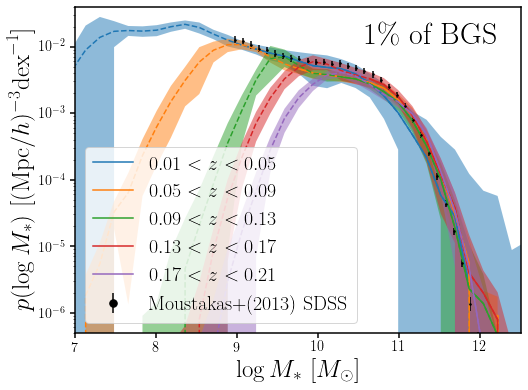

In [27]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(5), zmins, zmaxs):    
    # calculate normalization
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_any.z%.2f_%.2f.best.pt' % (zmin, zmax)), 
                            map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))

    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    h_jack = []
    for i_jack, field, A_field in zip(range(len(fields)), fields, A_fields): 
        # calculate normalization
        zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & ~field & (bgs['provabgs_w_zfail'].data > 0)
        norm = np.sum(w_import[zlim]) / ((v_zmax - v_zmin) / f_area * (A_field/(4.*np.pi*(180/np.pi)**2)))

        fgmm = os.path.join(dat_dir, 'psmf.gmm.bgs_any.z%.2f_%.2f.jack%i.best.pt' % (zmin, zmax, i_jack))
        psmf_model = torch.load(fgmm, map_location=device)
        with torch.no_grad(): 
            post_prime = psmf_model.sample((100000,))
        _h, _ = np.histogram(np.array(post_prime.detach().cpu()), 
                             weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
        h_jack.append(_h)
    h_jack = np.array(h_jack)
    
    #sub.plot(0.5*(be[:-1] + be[1:]), h, c='C%i' % i)
    #for h_j in h_jack:
    #    sub.plot(0.5*(be[:-1] + be[1:]), h_j, c='C%i' % i, ls='--')
    sig_jack = np.sqrt(float(len(fields)-1)/float(len(fields)) * np.sum((h_jack - np.mean(h_jack, axis=0))**2, axis=0))
        #_ = sub.hist(np.array(post_prime.detach().cpu()), range=(6., 13.), bins=40, 
        #             color='C%i' % i, histtype='step', linewidth=1)
    #sub.errorbar(0.5*(be[:-1] + be[1:]), h, yerr=sig_jack, c='C%i' % i)
    
    np.savetxt(os.path.join(dat_dir, 'psmf.sv3.bgs_any.z%.2f_%.2f.dat' % (zmin, zmax)),
              np.array([0.5*(be[:-1] + be[1:]), h, sig_jack]).T, 
              header='log stellar mass completeness limit %.2f' % mlim[2*i+1])
    
    sub.plot(0.5*(be[:-1] + be[1:]), h, color='C%i' % i, ls='--')
    sub.plot(0.5*(be[:-1] + be[1:])[be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], c='C%i' % i, ls='-')
    sub.fill_between(0.5*(be[:-1] + be[1:]), h-sig_jack, h+sig_jack, color='C%i' % i, edgecolor='none', alpha=0.5)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
    
    #sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    #sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
sub.errorbar(m13_logms, 10**m13_logsmf, 
             yerr=[10**m13_logsmf - 10**(m13_logsmf - m13_logsmf_sig), 10**(m13_logsmf + m13_logsmf_sig) - 10**m13_logsmf],
             fmt='.k', markersize=3, label='Moustakas+(2013) SDSS')

sub.legend(loc='lower left', fontsize=20, markerscale=5, frameon=True)
sub.set_xlabel(r'$\log M_*$  [$M_\odot$]', fontsize=25)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$  [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-7, 4e-2)
sub.text(0.95, 0.95, r'1\% of BGS', ha='right', va='top', fontsize=30, transform=sub.transAxes)
plt.show()